# Installing Keras Tuner

In [72]:
!pip install keras-tuner

# Importing Libraries

In [73]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np

In [74]:
tf.__version__

'2.12.0'

# Downloading Fashion-MNIST dataset

In [75]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [76]:
print(f'Train shape: {x_train.shape} and Test shape: {x_test.shape}')

Train shape: (60000, 28, 28) and Test shape: (10000, 28, 28)


In [77]:
print(f'Target| Train shape: {y_train.shape} and Test shape: {y_test.shape}')

Target| Train shape: (60000,) and Test shape: (10000,)


In [78]:
print(f'Labels in target: {set(y_train)}')

Labels in target: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


 **Visualizing the dataset**

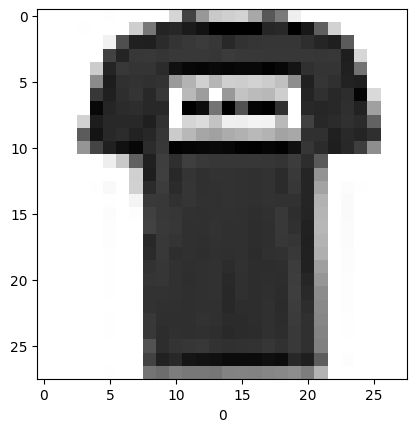

In [79]:
idx = 1
plt.imshow(x_train[idx], cmap = 'binary')
plt.xlabel(y_train[idx])
plt.show()

# Creating the Model with Hyperparameters

In [80]:
from keras.backend import dropout
def create_model(hp):

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
    num_units = hp.Choice('num_units', values=[8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
    learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value = 0.01)


  model = tf.keras.models.Sequential()
  # unroll input images
  model.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
  # normalizing the input
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range(num_hidden_layers):
    # FCN - fully connected layers
    model.add(tf.keras.layers.Dense(num_units, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  # Output layer
  model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

  model.compile(
      loss = 'sparse_categorical_crossentropy', # since the output is not one hot encoded
      optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate),
      metrics = ['accuracy']
  )

  return model

In [81]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


# Keras Tuner

In [91]:
class CustomTuner(kt.tuners.BayesianOptimization):
  # will find optimal batch size
  def run_trial(self, trial, *args, **kwargs):
    # experiments with certain hp values
    kwargs['batch_size']= trial.hyperparameters.Int('batch_size', 32, 128, step = 32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)
    # self.oracle.update_trial(trial.trial_id, {'val_accuracy': result.history['val_accuracy'][-1]})



In [92]:
tuner = CustomTuner(
    create_model,
    objective = 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'fashion_mnist',
    overwrite = True
    # overwrites the logs

)

In [93]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [94]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5, verbose = False,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)]
)

FatalTypeError: ignored

# Tuning Results

In [ ]:
tuner.results_summary(3)

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
_ = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 20,
    batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)]
)